# Predicting Usage of a Video Game Research Server - Individual Planning Report

Peti Setabandhu (41047416) - project-004-12

Link to GitHub repo: https://github.com/peteseta/dsci-100-project

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(janitor)
library(GGally)

options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.4.1 ──

✔ broom        1.0.10     ✔ rsample      1.3.1 
✔ dials        1.4.2      ✔ tailor       0.1.0 
✔ infer        1.0.9      ✔ tune         2.0.1 
✔ modeldata    1.5.1      ✔ workflows    1.3.0 
✔ parsnip      1.3.3      ✔ workflowsets 1.1.1 
✔ recipes      1.3.1      ✔ yardstick    1.3.2 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() mask

In [2]:
# load data files
players <- read_csv("https://raw.githubusercontent.com/peteseta/dsci-100-project/refs/heads/main/data/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# (1) Data Description:
<!-- Provide a full descriptive summary of the dataset, including information such as the number of observations, summary statistics (report values to 2 decimal places), number of variables, name and type of variables, what the variables mean, any issues you see in the data, any other potential issues related to things you cannot directly see, how the data were collected, etc. Make sure to use bullet point lists or tables to summarize the variables in an easy-to-understand format.

Note that the selected dataset(s) will probably contain more variables than you need. In fact, exploring how the different variables in the dataset affect your model may be a crucial part of the project. You need to summarize the full data regardless of which variables you may choose to use later on. -->

In [3]:
# quick summary of dataset
summary(players)

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

We will explore `players.csv`, which contains demographic and aggregate play information about each registered player.

There's also `sessions.csv`, which records individual gaming sessions, linked to each player by their hashed email.

### Players dataset
(196 players x 7 variables)

| Variable | Type | Description |
|---------------|------|-------------|
| `experience` | character | Player experience level - one of "Beginner", "Amateur", "Regular", "Pro", or "Veteran" |
| `subscribe` | logical | Whether player subscribes to newsletter |
| `hashedEmail` | character | Hash of player's email |
| `played_hours` | double | Playtime on the server (hours) |
| `name` | character | Player's name | 
| `gender` | character | Player's gender |
| `Age` | double | Player's age (years) |

### Summary statistics
- **Played hours:** Many players have 0 hours of playtime, with highest playing 223.1 hours. The average player played for 5.85 hours.
- **Age:** The youngest player was 9 and the oldest player was 58. The average player was 21.14 years old.
- **Distribution of experience levels:**
    <table class="dataframe">
    <tbody>
        <tr><td>Beginner</td><td>35</td></tr>
        <tr><td>Amateur </td><td>63</td></tr>
        <tr><td>Regular </td><td>36</td></tr>
        <tr><td>Pro     </td><td>14</td></tr>
        <tr><td>Veteran </td><td>48</td></tr>
    </tbody>
    </table>

### Data quality issues
- There are missing values (e.g. `age` contains an NA in the last row), which may bias the analysis.
- Many players have 0 recorded play hours - they registered but did not play at all.

# (2) Questions:
<!-- Clearly state one broad question that you will address, and the specific question that you have formulated. Your question should involve one response variable of interest and one or more explanatory variables, and should be stated as a question. One common question format is: “Can [explanatory variable(s)] predict [response variable] in [dataset]?”, but you are free to format your question as you choose so long as it is clear. Describe clearly how the data will help you address the question of interest. You may need to describe how you plan to wrangle your data to get it into a form where you can apply one of the predictive methods from this class. -->

**Broad question:**
> Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

**Specifically**: *can player demographic and experience level predict the total hours played on the PLAIcraft server?*

- Demograhphic information (age, gender, experience) can influence how much time a player spends on the server. Predicting whether someone is likely to contribute significant playtime will allow PLAIcraft to focus  recruitment on the most valuable players.
- I'll wrangle the data to format `experience` and `gender` as categorical factors and handle missing values/players with 0 recorded hours.



# (3) Exploratory Data Analysis and Visualization
<!-- In this assignment, you will:

- Demonstrate that the dataset can be loaded into R.
- Do the minimum necessary wrangling to turn your data into a tidy format. Do not do any additional wrangling here; that will happen later during the group project phase.
- Compute the mean value for each quantitative variable in the players.csv data set. Report the mean values in a table format.
- Make a few exploratory visualizations of the data to help you understand it.
Use our visualization best practices to make high-quality plots (make sure to include labels, titles, units of measurement, etc)
- Explain any insights you gain from these plots that are relevant to address your question -->

In [4]:
# wrangle data
players <- players |>
    clean_names() |>
    mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")), 
    gender = factor(gender)) |>
    drop_na()

players

experience,subscribe,hashed_email,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


In [5]:
# summary stats on players
players_stats <- players |>
    summarise(avg_played_hours = mean(played_hours, na.rm = TRUE),
              avg_age = mean(age, na.rm = TRUE))

# count of each experience factor
players_experience_count <- players |>
    count(experience)

players_stats
players_experience_count

avg_played_hours,avg_age
<dbl>,<dbl>
5.904639,21.13918


experience,n
<fct>,<int>
Beginner,35
Amateur,63
Regular,35
Pro,13
Veteran,48


`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


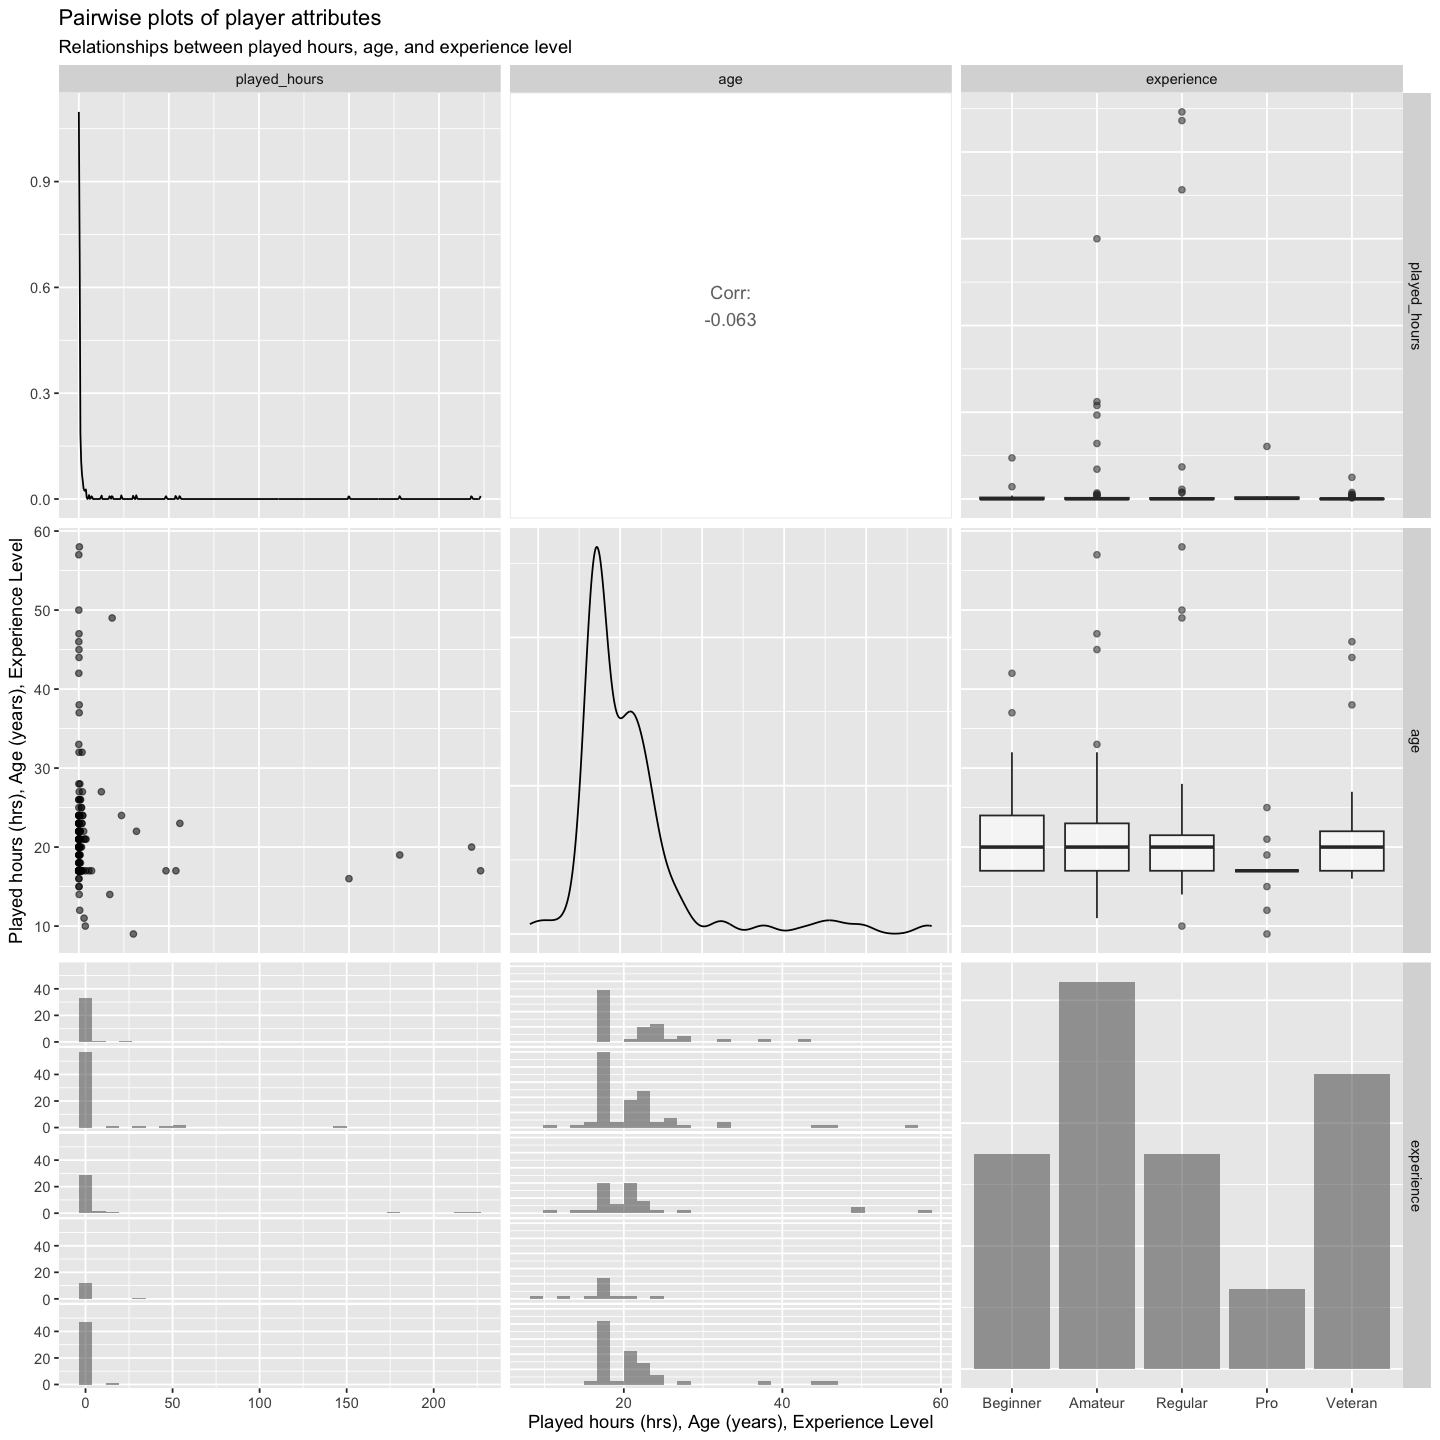

In [6]:
# preliminary visualization - pairplot
options(repr.plot.width = 12, repr.plot.height = 12)

players_pairs <- players |>
    select(played_hours, age, experience) |>
    ggpairs(mapping = aes(alpha = 0.4)) +
    labs(title = "Pairwise plots of player attributes",
         subtitle = "Relationships between played hours, age, and experience level",
         x = "Played hours (hrs), Age (years), Experience Level",
         y = "Played hours (hrs), Age (years), Experience Level")

players_pairs

- The modal experience level is "Amateur", followed by "Veteran" and seems uncorrelated with age
- Most players are 15-25, with a few older and younger outliers.
  - The outliers in played hours are mostly within the 15-20 age range
  - Everyone above 25 played fewer than 25 hours on the server (most close to or at 0 hours).
  - They self-rated as "Amateur" or "Regular," rather than more experienced.

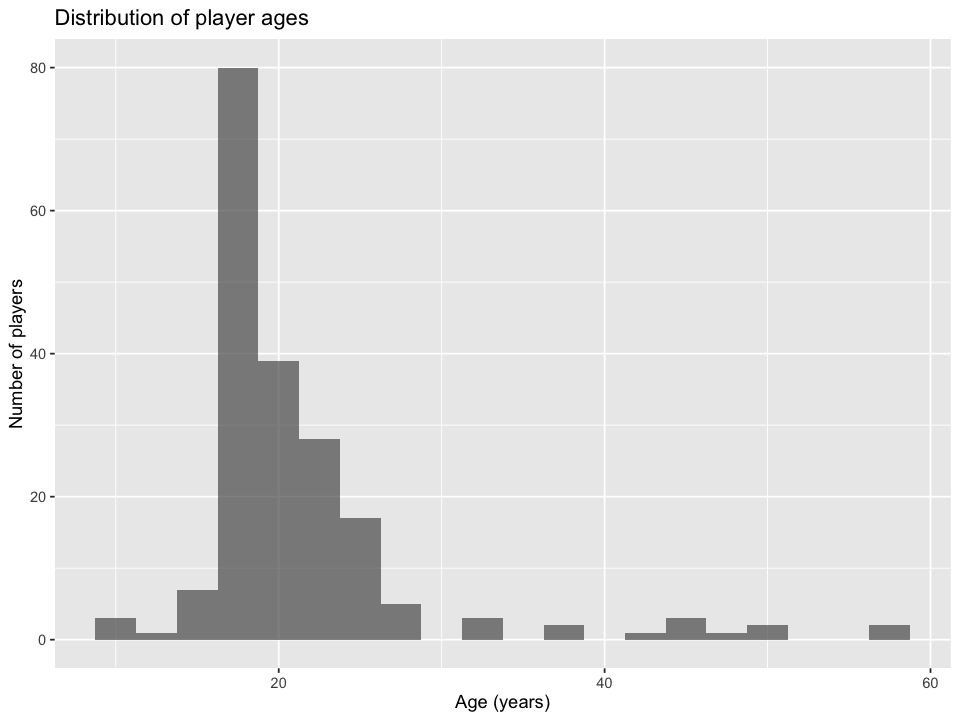

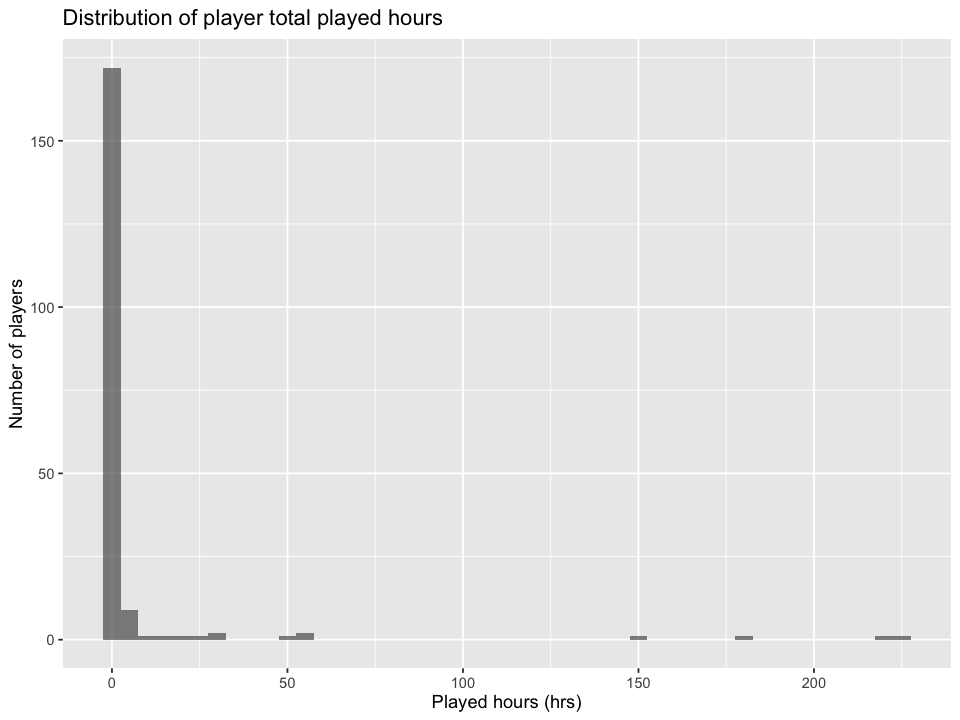

In [7]:
# preliminary visualization - distribution of age of players
options(repr.plot.width = 8, repr.plot.height = 6)
players_ages <- players |>
    ggplot(aes(x = age)) +
    geom_histogram(binwidth = 2.5, alpha = 0.7) +
    labs(title = "Distribution of player ages",
         x = "Age (years)",
         y = "Number of players")

players_ages

# preliminary visualization - distribution of played hours
players_played_hours <- players |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(binwidth = 5, alpha = 0.7) +
    labs(title = "Distribution of player total played hours",
         x = "Played hours (hrs)",
         y = "Number of players")

players_played_hours


- The modal bin for played hours is 0-5: many players registered but did not play at all or only played a few hours. 
- There are a few outliers, with small numbers of players playing for very long durations over the course of the study.

# (4) Methods and Plan
<!-- Propose one method to address your question of interest using the selected dataset and explain why it was chosen. Do not perform any modelling or present results at this stage. We are looking for high-level planning regarding model choice and justifying that choice.

In your explanation, respond to the following questions:

Why is this method appropriate?
Which assumptions are required, if any, to apply the method selected?
What are the potential limitations or weaknesses of the method selected?
How are you going to compare and select the model?
How are you going to process the data to apply the model? For example: Are you splitting the data? How? How many splits? What proportions will you use for the splits? At what stage will you split? Will there be a validation set? Will you use cross validation? -->

- I propose using K-NN regression, with `played_hours` as the response variable and `experience`, `gender`, `subscribe`, and `Age` as predictor variables.
- **Appropriateness** 
  - K-NN regression captures non-linear relationships without assuming a functional form.
- **Assumptions**
  - Similar instances of predictor variables will have similar response values. 
  - Predictors are on a comparable scale, so I'll need to standardize numeric predictors like age before applying the model.
- **Limitations**
  - Slower with larger datasets
  - Sensitive to k selection, which will be addressed with cross-validation.
- **Data processing** 
  - Data will be split into training (80%) and test (20%) sets. 
  - 5-fold cross-validation will be performed on the training set to tune the number of neighbors. 
  - The model's performance will be evaluated on the test set, using RMSPE to quantify how well it predicts played hours for unseen players.